In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import wntr
import wntr.metrics.economic as economics
import numpy as np
import pandas as pd
import pdb
import os

import sys
sys.path.append('../Code/')
from testWN import testWN as twm
from surrogate_model_training_data import get_data

from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [48]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
from surrogate_model_training_data import get_data

# Get network informations

In [50]:
inp_file = '../Code/c-town_true_network_simplified_controls.inp'
ctown = twm(inp_file)
nw_node_df = pd.DataFrame(ctown.wn.nodes.todict())
nw_link_df = pd.DataFrame(ctown.wn.links.todict())

node_names = ctown.getNodeName()
link_names = ctown.getLinkName()

# Data Pre-Processing

Get clusters:

In [51]:
cluster_label_path = '../clustering/'
cluster_labels = pd.read_json(cluster_label_path+'cluster_labels_dt1h.json')
pressure_factor = pd.read_json(cluster_label_path+'pressure_factor_dt1h.json')
n_clusters = 30

# Create Training Data:

In [103]:
data_path = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim_1hourSampling/'
file_list = os.listdir(data_path)[:50]
file_list = [data_path+file_i for file_i in file_list if '.pkl' in file_i]

data_path_2 = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim_noControls/'
file_list_2 = os.listdir(data_path_2)[:50]
file_list_2 = [data_path_2+file_i for file_i in file_list_2 if '.pkl' in file_i]

file_list.extend(file_list_2)

n_arx = 0
nn_input, nn_output = get_data(file_list, n_arx, cluster_labels, pressure_factor, narx_input=False)

/home/ffiedler/miniconda3/envs/py37_WNTR/lib/python3.7/site-packages/wntr/epanet/io.py:2088: UserWarning:

Not all curves were used in "../Code/c-town_true_network_simplified_controls.inp"; added with type None, units conversion left to user



### Normalize Data:

In [104]:
input_offset = 0*nn_input.mean()
nn_input_offset = nn_input - input_offset

input_scaling = nn_input_offset.abs().max()
input_scaling.loc[input_scaling.abs()<1e-5]=1e-5
nn_input_scaled = nn_input_offset/input_scaling

output_offset = 0*nn_output.mean()
nn_output_offset = nn_output - output_offset

output_scaling = nn_output_offset.abs().max()
output_scaling.loc[output_scaling.abs()<1e-5]=1e-5
nn_output_scaled = nn_output_offset/output_scaling

### Train / Test Splitting

In [105]:
X_train, X_test, Y_train, Y_test = train_test_split(nn_input_scaled, nn_output_scaled, test_size=0.2)

In [130]:
X_train.shape

(56448, 46)

# Neural Network

## Create Model

In [134]:
n_layer = 2
n_units = 100
l1_regularizer = 0

model_param = {}
model_param['n_in'] = nn_input.shape[1]
model_param['n_out'] = nn_output.shape[1]
model_param['n_units'] = (n_layer)*[n_units]
model_param['activation'] = (n_layer) * ['tanh']

inputs = keras.Input(shape=(model_param['n_in'],))

layer_list = [inputs]


for i in range(len(model_param['n_units'])-1):
    layer_list.append(
        keras.layers.Dense(model_param['n_units'][i],
                           activation=model_param['activation'][i],
                           kernel_regularizer=keras.regularizers.l1(l=l1_regularizer)
                           )(layer_list[i])
    )

outputs = keras.layers.Dense(model_param['n_out'],
                             activation='linear')(layer_list[-1])

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 46)]              0         
_________________________________________________________________
dense_23 (Dense)             (None, 100)               4700      
_________________________________________________________________
dense_24 (Dense)             (None, 42)                4242      
Total params: 8,942
Trainable params: 8,942
Non-trainable params: 0
_________________________________________________________________


## Train model

In [135]:
optim = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
callback = keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-8, patience=50, mode='min')
model.compile(optimizer=optim,
              loss='mse')

In [136]:
history = model.fit(X_train.to_numpy(), 
                    Y_train.to_numpy(), 
                    batch_size=5000, 
                    epochs=3000,
                    validation_data=(X_test.to_numpy(),Y_test.to_numpy()),
                    callbacks=[callback])

Train on 56448 samples, validate on 14112 samples
Epoch 1/3000
56448/56448 [==============================] - 1s 15us/sample - loss: 0.0799 - val_loss: 0.0395
Epoch 2/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 0.0358 - val_loss: 0.0301
Epoch 3/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0256 - val_loss: 0.0210
Epoch 4/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0194 - val_loss: 0.0170
Epoch 5/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0157 - val_loss: 0.0141
Epoch 6/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0132 - val_loss: 0.0121
Epoch 7/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0115 - val_loss: 0.0107
Epoch 8/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0102 - val_loss: 0.0096
Epoch 9/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0

Epoch 76/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 0.0048 - val_loss: 0.0048
Epoch 77/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0048 - val_loss: 0.0048
Epoch 78/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0048 - val_loss: 0.0048
Epoch 79/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0048 - val_loss: 0.0048
Epoch 80/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0047 - val_loss: 0.0048
Epoch 81/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0047 - val_loss: 0.0047
Epoch 82/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0047 - val_loss: 0.0047
Epoch 83/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0047 - val_loss: 0.0047
Epoch 84/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0047 - val_loss: 0.0047
Epoch 85/3000
56448

56448/56448 [==============================] - 0s 3us/sample - loss: 0.0039 - val_loss: 0.0040
Epoch 151/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0039 - val_loss: 0.0039
Epoch 152/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0039 - val_loss: 0.0039
Epoch 153/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0039 - val_loss: 0.0039
Epoch 154/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0039 - val_loss: 0.0039
Epoch 155/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0039 - val_loss: 0.0040
Epoch 156/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0039 - val_loss: 0.0039
Epoch 157/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0038 - val_loss: 0.0039
Epoch 158/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0038 - val_loss: 0.0039
Epoch 159/3000
56448/5644

56448/56448 [==============================] - 0s 3us/sample - loss: 0.0032 - val_loss: 0.0032
Epoch 225/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0032 - val_loss: 0.0032
Epoch 226/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0032 - val_loss: 0.0032
Epoch 227/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0031 - val_loss: 0.0032
Epoch 228/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0031 - val_loss: 0.0032
Epoch 229/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0031 - val_loss: 0.0032
Epoch 230/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0031 - val_loss: 0.0032
Epoch 231/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0031 - val_loss: 0.0032
Epoch 232/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0031 - val_loss: 0.0032
Epoch 233/3000
56448/5644

56448/56448 [==============================] - 0s 3us/sample - loss: 0.0027 - val_loss: 0.0028
Epoch 299/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0027 - val_loss: 0.0027
Epoch 300/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0026 - val_loss: 0.0027
Epoch 301/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0026 - val_loss: 0.0027
Epoch 302/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0026 - val_loss: 0.0027
Epoch 303/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0026 - val_loss: 0.0028
Epoch 304/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0027 - val_loss: 0.0027
Epoch 305/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0026 - val_loss: 0.0028
Epoch 306/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0027 - val_loss: 0.0028
Epoch 307/3000
56448/5644

56448/56448 [==============================] - 0s 3us/sample - loss: 0.0024 - val_loss: 0.0025
Epoch 373/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0023 - val_loss: 0.0024
Epoch 374/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0024 - val_loss: 0.0025
Epoch 375/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0024 - val_loss: 0.0024
Epoch 376/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0024 - val_loss: 0.0024
Epoch 377/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0024 - val_loss: 0.0025
Epoch 378/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0023 - val_loss: 0.0024
Epoch 379/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0023 - val_loss: 0.0024
Epoch 380/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0023 - val_loss: 0.0024
Epoch 381/3000
56448/5644

56448/56448 [==============================] - 0s 4us/sample - loss: 0.0022 - val_loss: 0.0023
Epoch 447/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0022 - val_loss: 0.0023
Epoch 448/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0022 - val_loss: 0.0023
Epoch 449/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0022 - val_loss: 0.0023
Epoch 450/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0022 - val_loss: 0.0023
Epoch 451/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0022 - val_loss: 0.0023
Epoch 452/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0022 - val_loss: 0.0023
Epoch 453/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0022 - val_loss: 0.0023
Epoch 454/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0022 - val_loss: 0.0023
Epoch 455/3000
56448/5644

56448/56448 [==============================] - 0s 4us/sample - loss: 0.0020 - val_loss: 0.0021
Epoch 521/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0020 - val_loss: 0.0021
Epoch 522/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0020 - val_loss: 0.0021
Epoch 523/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0020 - val_loss: 0.0021
Epoch 524/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0020 - val_loss: 0.0021
Epoch 525/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0020 - val_loss: 0.0021
Epoch 526/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0020 - val_loss: 0.0022
Epoch 527/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0021 - val_loss: 0.0022
Epoch 528/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0020 - val_loss: 0.0021
Epoch 529/3000
56448/5644

56448/56448 [==============================] - 0s 3us/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 595/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0019 - val_loss: 0.0021
Epoch 596/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0019 - val_loss: 0.0020
Epoch 597/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0019 - val_loss: 0.0020
Epoch 598/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0019 - val_loss: 0.0020
Epoch 599/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0019 - val_loss: 0.0020
Epoch 600/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0019 - val_loss: 0.0020
Epoch 601/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0019 - val_loss: 0.0020
Epoch 602/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0019 - val_loss: 0.0020
Epoch 603/3000
56448/5644

56448/56448 [==============================] - 0s 4us/sample - loss: 0.0019 - val_loss: 0.0020
Epoch 669/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0019 - val_loss: 0.0020
Epoch 670/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0019 - val_loss: 0.0020
Epoch 671/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0019 - val_loss: 0.0020
Epoch 672/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0019 - val_loss: 0.0020
Epoch 673/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0019 - val_loss: 0.0020
Epoch 674/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0019 - val_loss: 0.0020
Epoch 675/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0019 - val_loss: 0.0020
Epoch 676/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0019 - val_loss: 0.0020
Epoch 677/3000
56448/5644

56448/56448 [==============================] - 0s 4us/sample - loss: 0.0018 - val_loss: 0.0019
Epoch 743/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0018 - val_loss: 0.0019
Epoch 744/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0018 - val_loss: 0.0019
Epoch 745/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0018 - val_loss: 0.0019
Epoch 746/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0018 - val_loss: 0.0019
Epoch 747/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0018 - val_loss: 0.0019
Epoch 748/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0018 - val_loss: 0.0019
Epoch 749/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0018 - val_loss: 0.0019
Epoch 750/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0018 - val_loss: 0.0019
Epoch 751/3000
56448/5644

56448/56448 [==============================] - 0s 3us/sample - loss: 0.0017 - val_loss: 0.0018
Epoch 817/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0017 - val_loss: 0.0018
Epoch 818/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0017 - val_loss: 0.0019
Epoch 819/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0018 - val_loss: 0.0018
Epoch 820/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0017 - val_loss: 0.0018
Epoch 821/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0017 - val_loss: 0.0018
Epoch 822/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0017 - val_loss: 0.0018
Epoch 823/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0017 - val_loss: 0.0018
Epoch 824/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0017 - val_loss: 0.0018
Epoch 825/3000
56448/5644

56448/56448 [==============================] - 0s 3us/sample - loss: 0.0017 - val_loss: 0.0018
Epoch 891/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0017 - val_loss: 0.0018
Epoch 892/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0017 - val_loss: 0.0018
Epoch 893/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0017 - val_loss: 0.0018
Epoch 894/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0017 - val_loss: 0.0018
Epoch 895/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0017 - val_loss: 0.0017
Epoch 896/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0017 - val_loss: 0.0018
Epoch 897/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0017 - val_loss: 0.0018
Epoch 898/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0017 - val_loss: 0.0017
Epoch 899/3000
56448/5644

56448/56448 [==============================] - 0s 4us/sample - loss: 0.0016 - val_loss: 0.0017
Epoch 965/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0016 - val_loss: 0.0017
Epoch 966/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0016 - val_loss: 0.0017
Epoch 967/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0016 - val_loss: 0.0017
Epoch 968/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0016 - val_loss: 0.0017
Epoch 969/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0016 - val_loss: 0.0017
Epoch 970/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0016 - val_loss: 0.0017
Epoch 971/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0016 - val_loss: 0.0017
Epoch 972/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0016 - val_loss: 0.0017
Epoch 973/3000
56448/5644

56448/56448 [==============================] - 0s 4us/sample - loss: 0.0016 - val_loss: 0.0017
Epoch 1039/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0016 - val_loss: 0.0016
Epoch 1040/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0016 - val_loss: 0.0018
Epoch 1041/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0016 - val_loss: 0.0017
Epoch 1042/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0016 - val_loss: 0.0016
Epoch 1043/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0016 - val_loss: 0.0016
Epoch 1044/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0016 - val_loss: 0.0016
Epoch 1045/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0015 - val_loss: 0.0016
Epoch 1046/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0015 - val_loss: 0.0016
Epoch 1047/3000
5

Epoch 1112/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0015 - val_loss: 0.0016
Epoch 1113/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0015 - val_loss: 0.0016
Epoch 1114/3000
56448/56448 [==============================] - 1s 9us/sample - loss: 0.0015 - val_loss: 0.0016
Epoch 1115/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0015 - val_loss: 0.0016
Epoch 1116/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0015 - val_loss: 0.0016
Epoch 1117/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0015 - val_loss: 0.0017
Epoch 1118/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 0.0016 - val_loss: 0.0016
Epoch 1119/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0015 - val_loss: 0.0016
Epoch 1120/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0015 - val_loss: 0.0016
E

Epoch 1186/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0015 - val_loss: 0.0016
Epoch 1187/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0015 - val_loss: 0.0016
Epoch 1188/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0015 - val_loss: 0.0016
Epoch 1189/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0015 - val_loss: 0.0016
Epoch 1190/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0015 - val_loss: 0.0016
Epoch 1191/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0015 - val_loss: 0.0016
Epoch 1192/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0015 - val_loss: 0.0016
Epoch 1193/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0015 - val_loss: 0.0016
Epoch 1194/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0015 - val_loss: 0.0016
E

Epoch 1260/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 1261/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 1262/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 1263/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 1264/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 1265/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 1266/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 1267/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 1268/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0014 - val_loss: 0.0015
E

Epoch 1334/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 1335/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 1336/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 1337/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 1338/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 1339/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 1340/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 1341/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 1342/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0014 - val_loss: 0.0015
E

Epoch 1408/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 1409/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 1410/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 1411/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 1412/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 1413/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 1414/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 1415/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 1416/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0014 - val_loss: 0.0015
E

Epoch 1482/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0014 - val_loss: 0.0014
Epoch 1483/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 1484/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0014 - val_loss: 0.0014
Epoch 1485/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 1486/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 1487/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 1488/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 1489/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0014 - val_loss: 0.0014
Epoch 1490/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0013 - val_loss: 0.0014
E

Epoch 1556/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 1557/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 1558/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 1559/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 1560/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 1561/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0013 - val_loss: 0.0015
Epoch 1562/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 1563/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0013 - val_loss: 0.0015
Epoch 1564/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0013 - val_loss: 0.0015
E

Epoch 1630/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 1631/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 1632/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 1633/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 1634/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 1635/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 1636/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 1637/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 1638/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0013 - val_loss: 0.0014
E

Epoch 1704/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 1705/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 1706/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 1707/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 1708/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 1709/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 1710/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 1711/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 1712/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0013 - val_loss: 0.0014
E

Epoch 1778/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0013 - val_loss: 0.0013
Epoch 1779/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0013 - val_loss: 0.0013
Epoch 1780/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0013 - val_loss: 0.0013
Epoch 1781/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0013 - val_loss: 0.0013
Epoch 1782/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 1783/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 1784/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 1785/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0013 - val_loss: 0.0013
Epoch 1786/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0013 - val_loss: 0.0014
E

Epoch 1852/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0013 - val_loss: 0.0013
Epoch 1853/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 1854/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0013 - val_loss: 0.0013
Epoch 1855/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 1856/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 1857/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 1858/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 1859/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 1860/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0012 - val_loss: 0.0013
E

Epoch 1926/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 1927/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 1928/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0013 - val_loss: 0.0013
Epoch 1929/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 1930/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 1931/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 1932/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 1933/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 1934/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0012 - val_loss: 0.0013
E

Epoch 2000/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 2001/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 2002/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 2003/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 2004/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 2005/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 2006/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 2007/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 2008/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0012 - val_loss: 0.0013
E

Epoch 2074/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 2075/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 2076/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 2077/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 2078/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 2079/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 2080/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 2081/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 2082/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0012 - val_loss: 0.0013
E

Epoch 2148/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 2149/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 2150/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 2151/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 2152/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 2153/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 2154/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 2155/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 2156/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0012 - val_loss: 0.0013
E

Epoch 2222/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0012 - val_loss: 0.0012
Epoch 2223/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0012 - val_loss: 0.0012
Epoch 2224/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 2225/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 2226/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0012 - val_loss: 0.0012
Epoch 2227/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0012 - val_loss: 0.0012
Epoch 2228/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 2229/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 2230/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0012 - val_loss: 0.0013
E

Epoch 2296/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 2297/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0012 - val_loss: 0.0012
Epoch 2298/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2299/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2300/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0012 - val_loss: 0.0012
Epoch 2301/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0012 - val_loss: 0.0012
Epoch 2302/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0012 - val_loss: 0.0012
Epoch 2303/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0012 - val_loss: 0.0012
Epoch 2304/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0012 - val_loss: 0.0012
E

Epoch 2370/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2371/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2372/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2373/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2374/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2375/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2376/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0012 - val_loss: 0.0012
Epoch 2377/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2378/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0011 - val_loss: 0.0012
E

Epoch 2444/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2445/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2446/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2447/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2448/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2449/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2450/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2451/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2452/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0011 - val_loss: 0.0012
E

Epoch 2518/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2519/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2520/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2521/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2522/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2523/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2524/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 2525/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2526/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0011 - val_loss: 0.0012
E

Epoch 2592/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 2593/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2594/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2595/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2596/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2597/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2598/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2599/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 2600/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0011 - val_loss: 0.0012
E

Epoch 2666/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2667/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2668/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 2669/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2670/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2671/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2672/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2673/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2674/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0011 - val_loss: 0.0013
E

Epoch 2740/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2741/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2742/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2743/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2744/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2745/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2746/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2747/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2748/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0011 - val_loss: 0.0011
E

Epoch 2814/3000
56448/56448 [==============================] - 0s 8us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2815/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2816/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2817/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0011 - val_loss: 0.0011
Epoch 2818/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0011 - val_loss: 0.0011
Epoch 2819/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2820/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2821/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2822/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0011 - val_loss: 0.0012
E

Epoch 2888/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2889/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0011 - val_loss: 0.0011
Epoch 2890/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0011 - val_loss: 0.0011
Epoch 2891/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0011 - val_loss: 0.0011
Epoch 2892/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0011 - val_loss: 0.0011
Epoch 2893/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2894/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0011 - val_loss: 0.0011
Epoch 2895/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2896/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0011 - val_loss: 0.0011
E

Epoch 2962/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0011 - val_loss: 0.0011
Epoch 2963/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0010 - val_loss: 0.0011
Epoch 2964/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0011 - val_loss: 0.0011
Epoch 2965/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0011 - val_loss: 0.0011
Epoch 2966/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0011 - val_loss: 0.0011
Epoch 2967/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0010 - val_loss: 0.0011
Epoch 2968/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0010 - val_loss: 0.0011
Epoch 2969/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2970/3000
56448/56448 [==============================] - 0s 3us/sample - loss: 0.0011 - val_loss: 0.0011
E

Save model:

In [137]:
model_path = './models/'
model_name = '005_man_2x100_both_datasets'
model.save(model_path+model_name+'.h5')

train_data_param={
    'input_offset': input_offset,
    'input_scaling': input_scaling,
    'output_offset': output_offset,
    'output_scaling': output_scaling
}

with open(model_path+model_name+'_train_data_param.pkl','wb') as f:
    pickle.dump(train_data_param, f)

# Validation

In [148]:
data_path = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim_noControls/Validation/'
file_list = os.listdir(data_path)
file_list = [data_path+file_i for file_i in file_list if '.pkl' in file_i]

n_arx = 0
nn_input_val_list, nn_output_val_list = get_data(file_list, n_arx, cluster_labels, pressure_factor, narx_input=False, return_lists=True)

/home/ffiedler/miniconda3/envs/py37_WNTR/lib/python3.7/site-packages/wntr/epanet/io.py:2088: UserWarning:

Not all curves were used in "../Code/c-town_true_network_simplified_controls.inp"; added with type None, units conversion left to user



In [144]:
class simulator:
    def __init__(self, model, input_scaling, output_scaling, input_offset, output_offset, x0, t0):
        self.model = model
        
        self.input_scaling = input_scaling.to_numpy().reshape(1,-1)
        self.output_scaling = output_scaling.to_numpy().reshape(1,-1)
        self.input_offset = input_offset.to_numpy().reshape(1,-1)
        self.output_offset = output_offset.to_numpy().reshape(1,-1)
        
        self.x = x0
        self.n_x = x0.shape[1]
        self.aux = []
                
        self.t = np.array([t0]).reshape(-1,1)
        self.dt = 3600
            
    def eval_nn(self):
        # Scale input:
        self.nn_in = np.concatenate((self.x[[-1],:], self.u[[-1],:]),axis=1).reshape(1,-1)
        self.nn_in_scaled = (self.nn_in-self.input_offset)/self.input_scaling
        # Evaluate NN:
        self.nn_out_scaled = self.model.predict(self.nn_in_scaled)
        # Scale output:
        self.nn_out = self.nn_out_scaled*self.output_scaling+self.output_offset
#         x_new = self.nn_out[:,:self.n_x]
        x_new = self.x[[-1],:]+self.nn_out[:,:self.n_x]
        aux_new = self.nn_out[:,self.n_x:]
        self.aux.append(aux_new)
    
        self.x = np.append(self.x, x_new, axis=0)
        self.t = np.append(self.t, np.copy(self.t)[[-1]]+self.dt, axis=0)
        
        
    def next_step(self, sys_inputs_now):
        if 'u' in self.__dict__:
            self.u = np.append(self.u, sys_inputs_now.reshape(1,-1), axis=0)
        else:
            self.u = sys_inputs_now.reshape(1,-1)
        
        self.eval_nn()

In [149]:
val_i = 0

sys_states = nn_input_val_list[val_i]['sys_states']
sys_inputs = nn_input_val_list[val_i]['sys_inputs']
sys_aux_outputs = nn_output_val_list[val_i]['aux_outputs']

x0 = sys_states.head(1).to_numpy()
t0 = 0

nsim = simulator(model, input_scaling, output_scaling, input_offset, output_offset, x0, t0)

In [150]:
for k in range(100):
    print(k)
    sys_inputs_now = sys_inputs.iloc[k].to_numpy()
    nsim.next_step(sys_inputs_now)
sim_res = pd.DataFrame(nsim.x, columns=sys_states.columns, index=nsim.t.flatten())
sim_aux = pd.DataFrame(np.concatenate(nsim.aux), columns = sys_aux_outputs.columns,index=nsim.t.flatten()[:-1])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


<IPython.core.display.Javascript object>


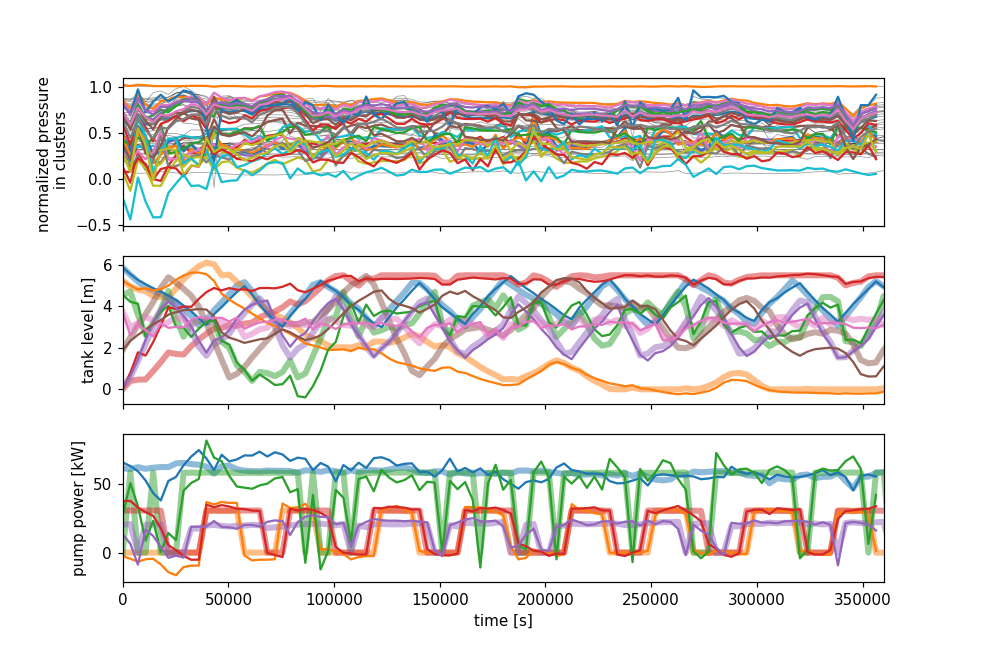

Text(0.5, 0, 'time [s]')

In [151]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(9,6))

sys_aux_outputs['jun_cl_press_mean'].plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
sim_aux['jun_cl_press_mean'].plot(ax=ax[0], legend=False)

sys_states['tank_press'].plot(ax=ax[1], legend=False, alpha=0.5, linewidth=4)
ax[1].set_prop_cycle(None)
sim_res['tank_press'].plot(ax=ax[1], legend=False)

sys_aux_outputs['pump_energy'].plot(ax=ax[2], legend=False, alpha=0.5, linewidth=4)
ax[2].set_prop_cycle(None)
sim_aux['pump_energy'].plot(ax=ax[2], legend=False)

ax[0].set_xlim(0, sim_res.index.max())
ax[0].set_ylabel('normalized pressure \n in clusters')
ax[1].set_ylabel('tank level [m]')
ax[2].set_ylabel('pump power [kW]')
ax[2].set_xlabel('time [s]')

# Linear Model

In [32]:
linear_reg = LinearRegression().fit(nn_input_scaled.to_numpy(), nn_output_scaled.to_numpy())

In [33]:
x0 = sys_states.head(1).to_numpy()
t0 = sys_states.head(1).index.to_numpy()

nsim_lin = simulator(linear_reg, input_scaling, output_scaling, input_offset, output_offset, x0, t0)

In [34]:
for k in range(100):
    print(k)
    sys_inputs_now = sys_inputs.iloc[k].to_numpy()
    nsim_lin.next_step(sys_inputs_now)
sim_res_lin = pd.DataFrame(nsim_lin.x, columns=sys_states.columns, index=nsim_lin.t.flatten())
sim_aux_lin = pd.DataFrame(np.concatenate(nsim_lin.aux), columns = sys_aux_outputs.columns,index=nsim_lin.t.flatten()[:-1])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


<IPython.core.display.Javascript object>


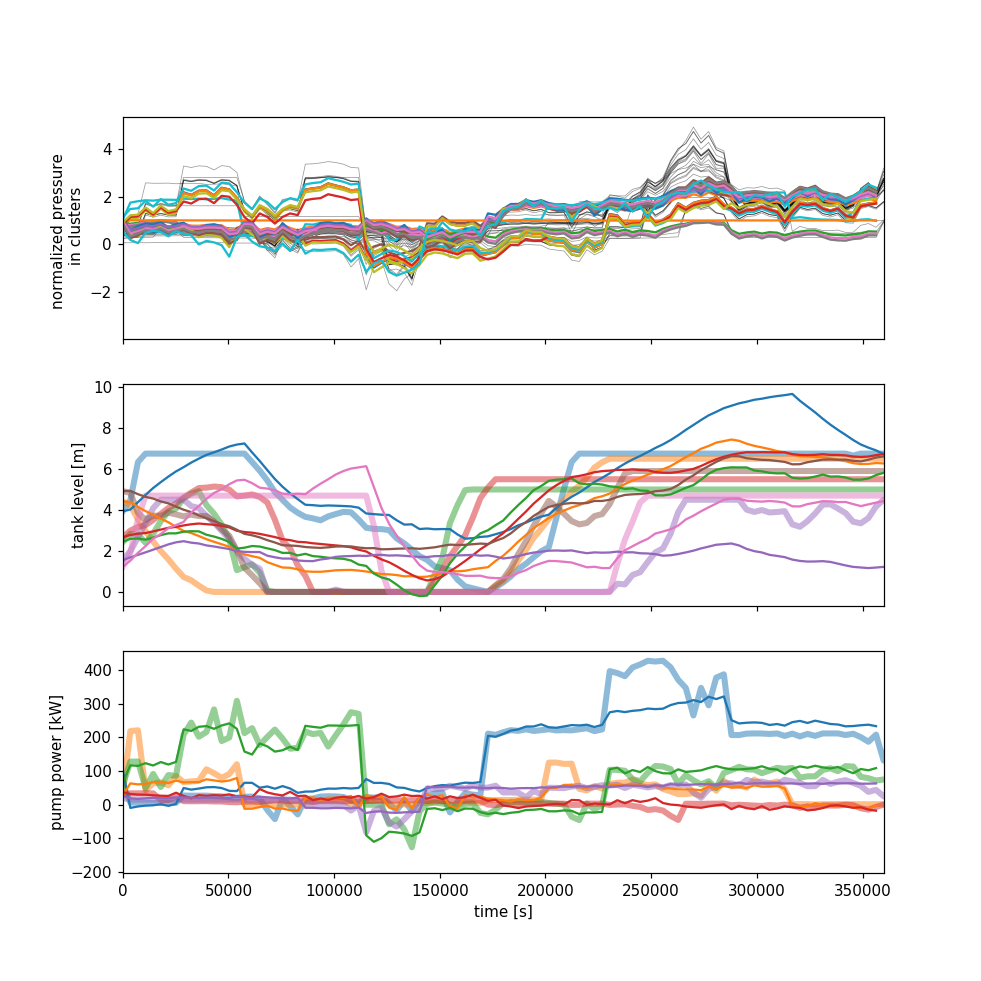

Text(0.5, 0, 'time [s]')

In [35]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(9,9))

sys_aux_outputs['jun_cl_press_mean'].plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
sim_aux_lin['jun_cl_press_mean'].plot(ax=ax[0], legend=False)

sys_states['tank_press'].plot(ax=ax[1], legend=False, alpha=0.5, linewidth=4)
ax[1].set_prop_cycle(None)
sim_res_lin['tank_press'].plot(ax=ax[1], legend=False)

sys_aux_outputs['pump_energy'].plot(ax=ax[2], legend=False, alpha=0.5, linewidth=4)
ax[2].set_prop_cycle(None)
sim_aux_lin['pump_energy'].plot(ax=ax[2], legend=False)

ax[0].set_xlim(0, sim_res_lin.index.max())
ax[0].set_ylabel('normalized pressure \n in clusters')
ax[1].set_ylabel('tank level [m]')
ax[2].set_ylabel('pump power [kW]')
ax[2].set_xlabel('time [s]')